<a href="https://colab.research.google.com/github/mahima110298/PatternRecognition/blob/main/skin_care_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Care Detection Using Pattern Recognition
**CECS 550 FINAL PROJECT**

**Team Members:**
- Mahima Sachan
- Divyakumar Gajera
- Sahil Vanjara

**Project Description:**
The goal of this project is to develop a pattern recognition-based system capable of detecting and classifying various types of skin conditions using dermatoscopic images. By applying machine learning and image processing techniques, we aim to identify patterns that distinguish between benign and malignant skin lesions.

**Dataset:** [HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.9.0+cu126
Using device: cuda


In [2]:
# Configuration & Download
import kagglehub

# Download latest version
print("Downloading dataset...")
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)

DATA_DIR = path # Use the downloaded path
METADATA_PATH = os.path.join(DATA_DIR, "HAM10000_metadata.csv")

print(f"Looking for data in: {os.path.abspath(DATA_DIR)}")

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000
Looking for data in: /kaggle/input/skin-cancer-mnist-ham10000


In [3]:
# 1. Load Data and Map Images
try:
    skin_df = pd.read_csv(METADATA_PATH)

    # Create a dictionary mapping image_id to the actual image path
    # This handles cases where images are in subfolders
    image_path_map = {os.path.splitext(os.path.basename(x))[0]: x
                      for x in glob(os.path.join(DATA_DIR, '**', '*.jpg'), recursive=True)}

    skin_df['path'] = skin_df['image_id'].map(image_path_map)

    # Filter out rows where image was not found
    if skin_df['path'].isnull().any():
        print(f"Warning: {skin_df['path'].isnull().sum()} images not found.")
        skin_df = skin_df.dropna(subset=['path'])

    # Add a readable diagnosis column for better visualization
    lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }
    skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict).astype('category')

    print("Data loaded successfully!")
    print(skin_df.head())

except FileNotFoundError:
    print("Error: HAM10000_metadata.csv not found. Please download the dataset.")
    # Create a dummy dataframe so the notebook structure is valid even without data
    skin_df = pd.DataFrame(columns=['image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'path', 'cell_type'])

Data loaded successfully!
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
3  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
4  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   

                       cell_type  
0  Benign keratosis-like lesions  
1  Benign keratosis-like lesions  
2  Benign keratosis-like lesions  
3  Benign keratosis-like lesions  
4  Benign keratosis-like lesions  


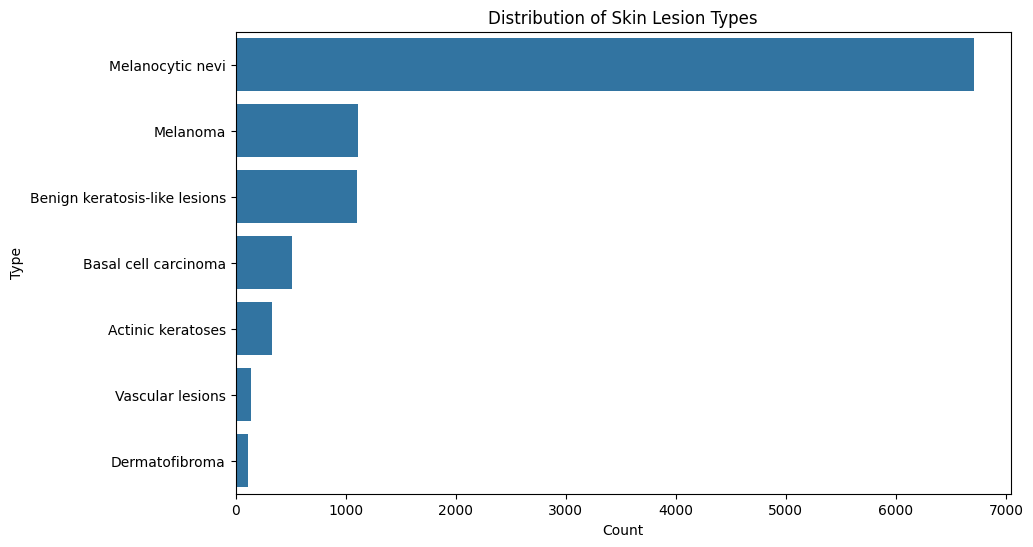

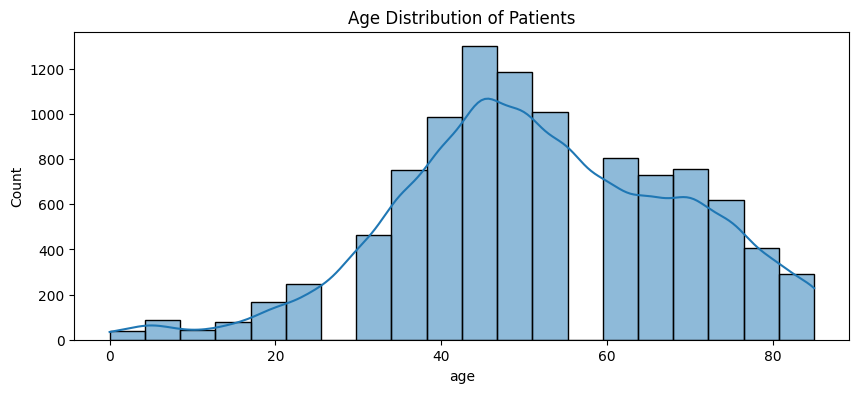

In [4]:
# 2. Exploratory Data Analysis (EDA)
if not skin_df.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='cell_type', data=skin_df, order=skin_df['cell_type'].value_counts().index)
    plt.title('Distribution of Skin Lesion Types')
    plt.xlabel('Count')
    plt.ylabel('Type')
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(skin_df['age'], bins=20, kde=True)
    plt.title('Age Distribution of Patients')
    plt.show()
else:
    print("No data to visualize.")

In [5]:
# 3. Data Preprocessing & PyTorch Dataset
IMG_SIZE = 32

# Define a custom Dataset
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label_idx']

        if self.transform:
            image = self.transform(image)

        return image, label

if not skin_df.empty:
    # Encode labels to integers (0-6)
    le = LabelEncoder()
    skin_df['label_idx'] = le.fit_transform(skin_df['dx'])

    # Split the dataframe
    train_df, test_df = train_test_split(skin_df, test_size=0.20, random_state=42)

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create DataLoaders
    train_dataset = SkinDataset(train_df, transform=transform)
    test_dataset = SkinDataset(test_df, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    print(f"Training samples: {len(train_df)}")
    print(f"Testing samples: {len(test_df)}")
    print(f"Classes: {len(le.classes_)}")
else:
    print("Skipping preprocessing (no data).")
    train_loader, test_loader = None, None

Training samples: 8012
Testing samples: 2003
Classes: 7


In [6]:
# 4. Model Building (Simple CNN in PyTorch)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            # Block 3
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

if train_loader is not None:
    model = SimpleCNN(num_classes=7).to(device)
    print(model)
else:
    print("Skipping model building.")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(

Starting training...
Epoch [1/10], Loss: 0.8752, Accuracy: 0.6867
Epoch [2/10], Loss: 0.7383, Accuracy: 0.7229
Epoch [3/10], Loss: 0.6907, Accuracy: 0.7435
Epoch [4/10], Loss: 0.6462, Accuracy: 0.7584
Epoch [5/10], Loss: 0.6176, Accuracy: 0.7716
Epoch [6/10], Loss: 0.5799, Accuracy: 0.7869
Epoch [7/10], Loss: 0.5510, Accuracy: 0.7921
Epoch [8/10], Loss: 0.5114, Accuracy: 0.8097
Epoch [9/10], Loss: 0.4889, Accuracy: 0.8160
Epoch [10/10], Loss: 0.4440, Accuracy: 0.8344


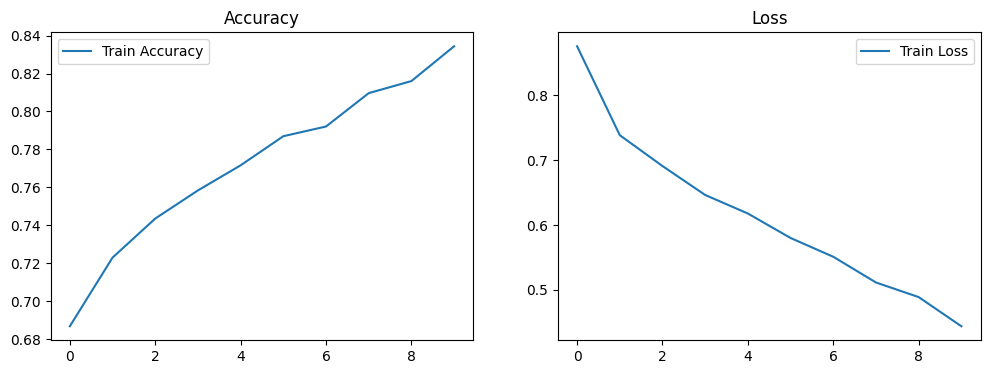

In [7]:
# 5. Training
if train_loader is not None:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    train_losses = []
    train_accs = []

    print("Starting training...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
else:
    print("Skipping training.")

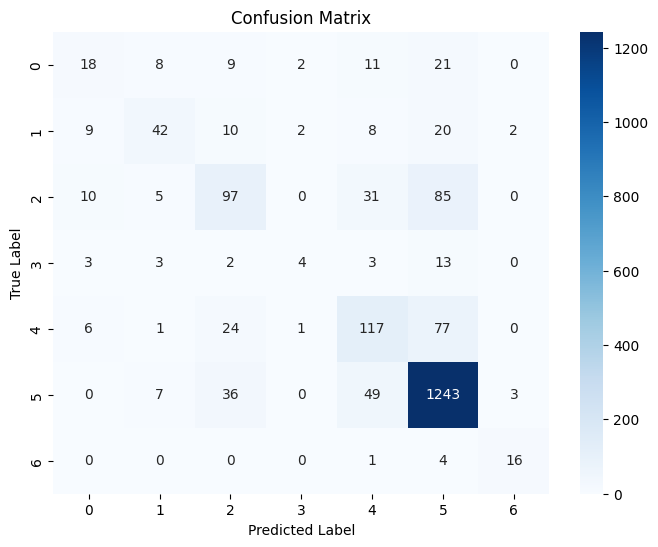

              precision    recall  f1-score   support

           0       0.39      0.26      0.31        69
           1       0.64      0.45      0.53        93
           2       0.54      0.43      0.48       228
           3       0.44      0.14      0.22        28
           4       0.53      0.52      0.52       226
           5       0.85      0.93      0.89      1338
           6       0.76      0.76      0.76        21

    accuracy                           0.77      2003
   macro avg       0.59      0.50      0.53      2003
weighted avg       0.75      0.77      0.75      2003



In [8]:
# 6. Evaluation
if test_loader is not None:
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(classification_report(all_labels, all_preds))
else:
    print("Skipping evaluation.")